In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.model_selection import RandomizedSearchCV
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from deep_translator import GoogleTranslator

In [2]:
og_protests_df = pd.read_csv("./data/protests.csv")
og_protests_df.event_date = pd.to_datetime(og_protests_df.event_date)
og_protests_df.sort_values(by="event_date", inplace=True)
# Protest data from 2019 looks highly suspicious - less than 10% as many
# protests as 2020 with around 1/30th or 1/40th as many total protesters
og_protests_df = og_protests_df[og_protests_df['event_date'] >= '2020-01-01']
og_protests_df = og_protests_df[['event_date', 'tags']]
og_protests_df.event_date.iloc[-1]

Timestamp('2024-07-12 00:00:00')

In [3]:
speeches_df = pd.read_csv('./data/speeches.csv.gz', escapechar="\\", compression="gzip")
speeches_df["date"] = pd.to_datetime(speeches_df["date"])
speeches_df = speeches_df[~speeches_df.date.isna()]
speeches_df = speeches_df.sort_values('date')

In [4]:
first_protest = og_protests_df.event_date.iloc[0]
first_speech = speeches_df.date.iloc[0]
last_recorded_protest = og_protests_df.event_date.iloc[-1]
last_recorded_speech = speeches_df.date.iloc[-1]
print(f'First speech: {first_speech}')
print(f'First protest: {first_protest}')
print(f'Last recorded speech: {last_recorded_speech}')
print(f'Last recorded protest: {last_recorded_protest}')
# og_protests_df.event_date.iloc[0], speeches_df.date.iloc[0], og_protests_df.event_date.iloc[-1], speeches_df.date.iloc[-1]

First speech: 2002-03-19 00:00:00
First protest: 2020-01-01 00:00:00
Last recorded speech: 2024-09-29 00:00:00
Last recorded protest: 2024-07-12 00:00:00


In [5]:
# Drop speeches outside the dates for which we have convincing protest data
# speeches_df = speeches_df[(speeches_df['date'] >= '2020-03-19') & (speeches_df['date'] <= last_recorded_protest)]
speeches_df = speeches_df[(speeches_df['date'] >= '2020-01-01') & (speeches_df['date'] <= last_recorded_protest)]

# Drop protests after the last speech for which we have a complete protest record
og_protests_df = og_protests_df[og_protests_df['event_date'] <= speeches_df.date.iloc[-1]]

# speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df.sort_values(by="date")
speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df[~speeches_df['text'].isna()]
speeches_df.head(1)

,date,text
223,2020-01-15,\n \n2019 - 2024 \n \n \nПЪЛЕН ПРОТОКОЛ Н...


In [6]:
first_relevant_protest = og_protests_df.event_date.iloc[0]
first_relevant_speech = speeches_df.date.iloc[0]
last_relevant_protest = og_protests_df.event_date.iloc[-1]
last_relevant_speech = speeches_df.date.iloc[-1]
print(f'First relevant speech: {first_relevant_speech}')
print(f'First relevant protest: {first_relevant_protest}')
print(f'Last relevant speech: {last_relevant_speech}')
print(f'Last relevant protest: {last_relevant_protest}')

First relevant speech: 2020-01-15 00:00:00
First relevant protest: 2020-01-01 00:00:00
Last relevant speech: 2024-03-19 00:00:00
Last relevant protest: 2024-03-19 00:00:00


In [7]:
def preprocess(text):
  pattern = re.compile(r'\.+.*\.+') # delete first section with '...'
  text = pattern.sub(r'', text)
  pattern = re.compile(r"\n") # delete new line markers
  text = pattern.sub(r'', text)
  text = re.sub(r'\s+', ' ', text) # delete additional whitespace between words
  text = text.lower()
  return text

In [8]:
speeches_df["clean_text"] = speeches_df["text"].progress_apply(preprocess)

  0%|          | 0/226 [00:00<?, ?it/s]

In [9]:
# Fill missing values in the "text" column with empty strings
speeches_df["clean_text"] = speeches_df["clean_text"].fillna("")

# Group by day and aggregate the text
speeches_df = speeches_df.groupby(speeches_df["date"]).agg({"clean_text": " ".join})
len(speeches_df)

66

In [10]:
speeches_df['speech_length'] = speeches_df["clean_text"].str.len()
# speech_lengths.index = speech_lengths.index.to_timestamp()
# speech_lengths = speech_lengths.rename("speech_count")
# speech_lengths = speech_lengths.to_frame()

In [11]:
speeches_df.head(2)

,clean_text,speech_length
date,,
2020-01-15,2019 - 2024 пълен протокол на разискванията d...,646375
2020-01-29,2019 - 2024 пълен протокол на разискванията d...,448030


In [12]:
# translate keywords to eu-languages
keywords = "climate change"
eu_lang = ['bg','cs','da','de','el','en','es','et','fi','fr','ga','hr','hu','it','lt','lv','mt','nl','pl','pt','ro','sk','sl','sv']
keywords_translated = []
for i in eu_lang:
  translated = GoogleTranslator(source='auto', target=i).translate(text=keywords)
  keywords_translated.append(translated)
keywords_eu_lang = "|".join(keywords_translated).lower()

In [13]:
speeches_df['climate_mentions_percent'] = (speeches_df["clean_text"].str.count(keywords_eu_lang) / speeches_df["clean_text"].str.split().str.len())*100
speeches_df.drop('clean_text', axis=1, inplace=True)
speeches_df.head()

,speech_length,climate_mentions_percent
date,,
2020-01-15,646375,0.011048
2020-01-29,448030,0.014015
2020-02-12,716390,0.018191
2020-03-19,10207308,0.021141
2020-05-13,230860,0.008285


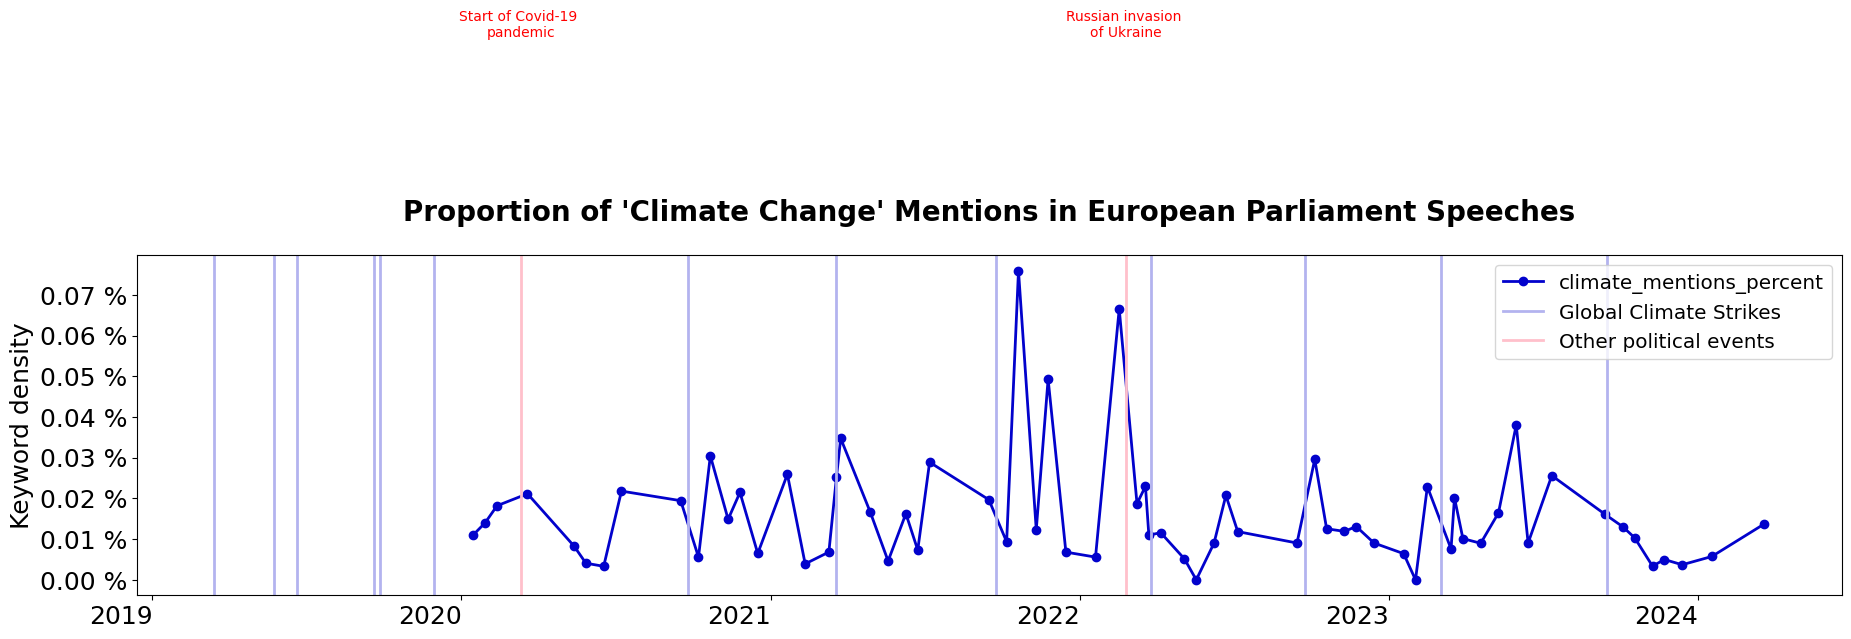

In [14]:
fig, ax = plt.subplots(figsize=(22, 5))
speeches_df['climate_mentions_percent'].plot(ax=ax, marker='o', linestyle='-', linewidth=2, color="#0202cc", fontsize=18)

ax.set_title("Proportion of 'Climate Change' Mentions in European Parliament Speeches", fontsize=20, fontweight = "bold", pad=25)
ax.set_ylabel("Keyword density",fontsize=18)
ax.set_xlabel("")

def format_func(value, tick_number):
  return '{:.2f} %'.format(value)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

gcs_dates = ["2019-03-15", "2019-05-24", "2019-06-21", "2019-09-20", "2019-09-27", "2019-11-29", "2020-09-25", "2021-03-19", "2021-09-24", "2022-03-25", "2022-09-23", "2023-03-03", "2023-09-15"]
for i in gcs_dates:
  plt.axvline(x = i, color = '#b3b3ef', label = 'Global Climate Strikes', linewidth=2)

fig.autofmt_xdate()

plt.axvline(x = "2020-03-11", color = 'pink', label = 'Other political events', linewidth=2)
plt.axvline(x = "2022-02-24", color = 'pink', label = 'Other political events', linewidth=2)
ax.text("2020-03-11", 0.14, "Start of Covid-19 \npandemic", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")
ax.text("2022-02-24", 0.14, "Russian invasion \nof Ukraine", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")

# Remove legend
# ax.legend().remove()
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
legend_dict = {label: handle for handle, label in zip(handles, labels)}
legend_dict.pop('speech_count', None)

# Create legend for each color
plt.legend(legend_dict.values(), legend_dict.keys(), loc='upper right', fontsize="x-large")


# Rotate x-axis tick labels
plt.xticks(rotation=0)

plt.show()

Example ACLED citation:

Raleigh, C., Kishi, R. & Linke, A. Political instability patterns are obscured by conflict dataset scope conditions, sources, and coding choices. Humanit Soc Sci Commun 10, 74 (2023). https://doi.org/10.1057/s41599-023-01559-4

(cf https://developer.acleddata.com/dashboard/terms-of-use/)

In [15]:
def infer_crowd_size(tag):
  """Convert the text strings giving estimated protester counts (sometimes as a
  range) into an integer (in the middle of the range)"""

  # Start with the numerous special cases
  if any (s in tag for s in ("several", "multiple", "a few", "some", "a group",
    "a small group", "small group", "a couple", "half dozen", "half-dozen",
    "half a dozen", "a handful", "handful", "small")
  ):
    return 5

  estimates = {
    ("hundreds", "hundred"): 500,
    ("between hundreds and 2000",): 2750,
    ("thousands", "thousand"): 5000,
    ("tens of thousands",): 50_000,
    ("hundreds of thousands",): 500_000,
    ("between dozens and 250",): (50+250)//2,
    ("one to three",): 2,
    ("two dozens",): 24
  }

  for text, estimate in estimates.items():
    if any (s in tag for s in text):
      return estimate

  if any (s in tag for s in ("dozens", "tens", "tenfold", "scores", "big group",
    "large group", "numerous", "many", "large number", "numerous small groups",
    "large", "multitude")):
    return 50

  # Regex to capture Arabic numbers that may or may not include commas:
  number_pattern = '\d{1,3}(?:,?\d*)*'
  numbers = re.findall(number_pattern, tag)
  # Remove commas from numbers and then convert them to integers
  numbers = [int(num.replace(',', '')) for num in numbers]

  # If we have two or more numbers, assume it's a range, and take their mean
  mean = np.mean(numbers)

  if tag.endswith("dozen") and any(numbers):
    return mean * 12
  if tag.endswith("dozen"):
    return 12

  # Don't replace NaNs yet
  if np.isnan(mean):
    return np.nan
  return int(round(mean))

og_protests_df['protesters_estimate'] = og_protests_df['tags'].apply(infer_crowd_size)
og_protests_df['size_is_unknown'] = og_protests_df['protesters_estimate'].isna().astype(int)

/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
def assign_group(date):
    idx = speeches_df.index.searchsorted(date)
    if idx == len(speeches_df.index):
        return speeches_df.index[-1]  # Return the last speech date for dates after the last speech
    return speeches_df.index[idx]

og_protests_df['next_speech_date'] = og_protests_df['event_date'].apply(assign_group)

In [17]:
# Group the protests by when the subsequent speech was, but retain info of how many of them there were,
# and of those, how many were unknown, since we need to retrospectively impute
# these later

num_protests = og_protests_df.groupby('next_speech_date').size()

protests_df = og_protests_df.groupby('next_speech_date').agg({
    'protesters_estimate': 'sum',
    'size_is_unknown': 'sum'
}).assign(num_protests=og_protests_df.groupby('next_speech_date').size())

In [18]:
protests_df.index = pd.to_datetime(protests_df.index)

# Some speeches don't have any record of protests between them. For now,
# we'll take that at face value and assume that means there were no protests
protests_df = protests_df.reindex(speeches_df.index, fill_value=0)

# Calculate the difference in days using a list comprehension
days_diff = [0] + [(protests_df.index[i] - protests_df.index[i-1]).days
                   for i in range(1, len(protests_df))]

# Add the new column to the dataframe
protests_df['days_since_last'] = days_diff

# Fill the first row's value with number of days between start of protest data
# and the first speech in our date range
protests_df.loc[protests_df.index[0], 'days_since_last'] = (protests_df.index[0] - first_protest).days




In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from scipy.stats import uniform, randint

class ProtestSizeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, assumed_size=3000):
        self.assumed_size = assumed_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_estimate'] = X['protesters_estimate'] + X['size_is_unknown'] * self.assumed_size
        return X

class ProtestTimeAccounter(BaseEstimator, TransformerMixin):
    """Averages the number of protesters over number of days between speeches"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_per_day_estimate'] = X['protesters_estimate'] / X['days_since_last']
        return X

class ProtestStockCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, decay_param=0.99, initial_stock=600_000):
        self.decay_param = decay_param
        self.initial_stock = initial_stock

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        protest_stock = np.zeros(len(X))
        protest_stock[0] = self.initial_stock + X['protesters_per_day_estimate'].iloc[0]
        for t in range(1, len(X)):
            # Treating speeches themselves as the unit of time
            # protest_stock[t] = X['protesters_per_day_estimate'].iloc[t] + self.decay_param * protest_stock[t-1]

            # Partially accounting for time between speeches
            protest_stock[t] = X['protesters_per_day_estimate'].iloc[t] + self.decay_param ** (X['days_since_last'].iloc[t]) * protest_stock[t-1]
        return pd.DataFrame({'protest_stock': protest_stock.flatten()}, index=X.index)
        # X['protest_stock'] = protest_stock
        # return X['protest_stock']



# Create the full pipeline
pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('protest_time_accounter', ProtestTimeAccounter()),
    ('protest_stock_calculator', ProtestStockCalculator()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

# Set up RandomizedSearchCV
param_distributions = {
    'protest_stock_calculator__decay_param': uniform(0.4, 0.6),
    'protest_stock_calculator__initial_stock': randint(0, 50_000),
    'protest_size_imputer__assumed_size': randint(0, 5000),
}

# Assuming you have your data in protests_df and y
y = speeches_df['climate_mentions_percent']

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=100,
    random_state=42# adjust as needed
)

# Fit the random search
random_search.fit(protests_df, y)

# Get best parameters
print(random_search.best_params_)

# Get the best estimator
best_model = random_search.best_estimator_

# You can now use best_model to make predictions
# predictions = best_model.predict(new_data)

# Time-insensitive model
# {'protest_size_imputer__assumed_size': 527, 'protest_stock_calculator__decay_param': 0.9229701077973101, 'protest_stock_calculator__initial_stock': 211}
# {'protest_size_imputer__assumed_size': 4924, 'protest_stock_calculator__decay_param': 0.922730372125585, 'protest_stock_calculator__initial_stock': 1337}


# Time-sensitive model

{'protest_size_imputer__assumed_size': 4499, 'protest_stock_calculator__decay_param': np.float64(0.9322518545590703), 'protest_stock_calculator__initial_stock': 12183}


In [20]:
assumed_size = random_search.best_params_['protest_size_imputer__assumed_size']
decay_param = random_search.best_params_['protest_stock_calculator__decay_param']
initial_stock = random_search.best_params_['protest_stock_calculator__initial_stock']

# assumed_size = 860
# decay_param = 0.55
# initial_stock = 25_000

data_transform = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('protest_time_accounter', ProtestTimeAccounter()),
  ('protest_stock_calculator', ProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
])

data_scaler = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('protest_time_accounter', ProtestTimeAccounter()),
  ('protest_stock_calculator', ProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
  ('scaler', RobustScaler())
])

adstock_df = data_transform.fit_transform(protests_df)
adstock_arr = data_scaler.fit_transform(protests_df)

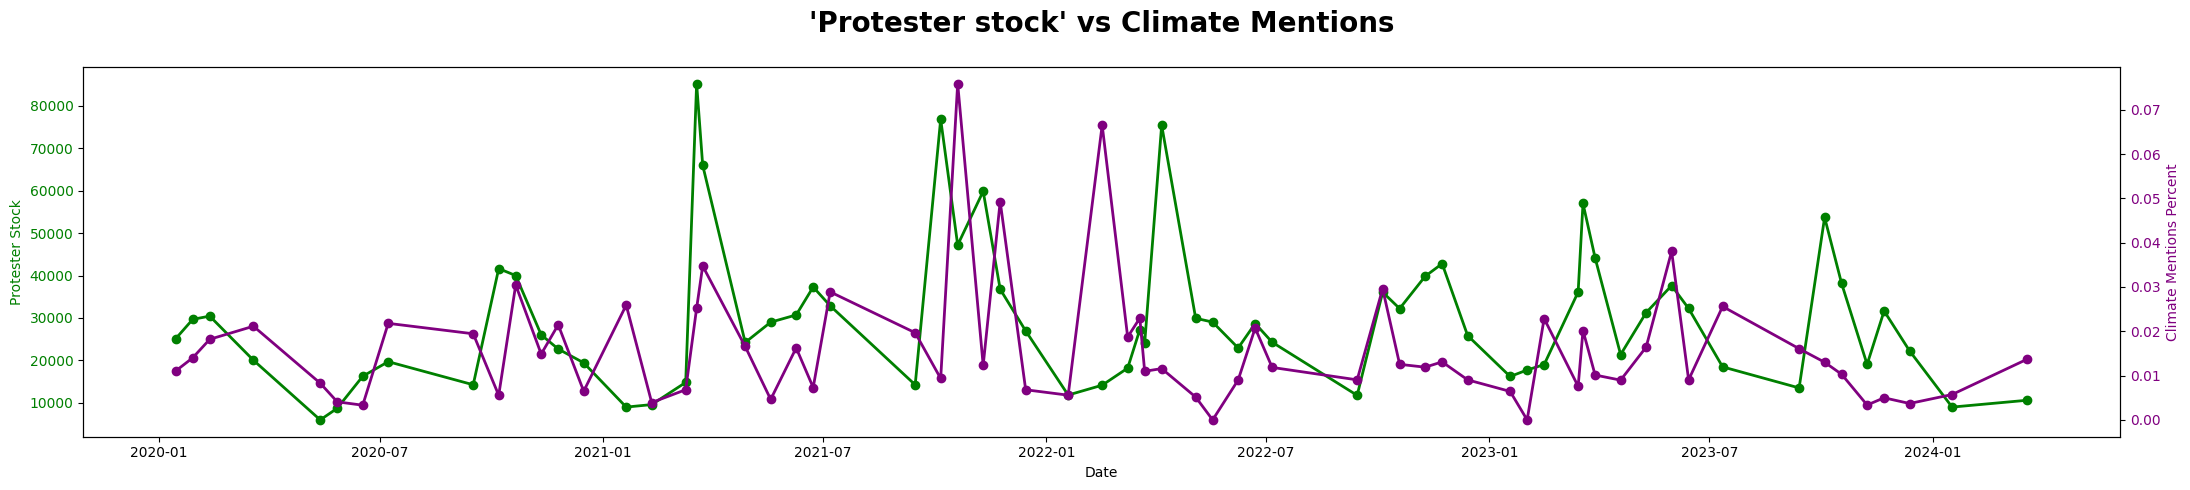

In [21]:
fig, ax1 = plt.subplots(figsize=(22, 5))

protester_color = 'green'
# Plot protest_stock on the primary y-axis
ax1.plot(speeches_df.index, adstock_df['protest_stock'], marker='o', linestyle='-', linewidth=2, color=protester_color)
ax1.set_xlabel("Date")
ax1.set_ylabel("Protester Stock", color=protester_color)
ax1.tick_params(axis='y', labelcolor=protester_color)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot climate_mentions_percent on the secondary y-axis
climate_mentions_color = "purple"
ax2.plot(speeches_df.index, y, marker='o', linestyle='-', linewidth=2, color=climate_mentions_color)
ax2.set_ylabel("Climate Mentions Percent", color=climate_mentions_color)
ax2.tick_params(axis='y', labelcolor=climate_mentions_color)

# Set title
plt.title("'Protester stock' vs Climate Mentions", fontsize=20, fontweight="bold", pad=25)

# Adjust layout to prevent clipping of labels
fig.tight_layout()

plt.show()

In [22]:
protests_df['protester_stock'] = adstock_df['protest_stock']
protests_df['climate_mentions_percent'] = y
protests_df.corr()

,protesters_estimate,size_is_unknown,num_protests,days_since_last,protester_stock,climate_mentions_percent
protesters_estimate,1.000000,0.629413,0.718126,0.025410,0.528316,-0.059986
size_is_unknown,0.629413,1.000000,0.968807,0.591478,0.256593,-0.055353
num_protests,0.718126,0.968807,1.000000,0.502487,0.320098,-0.065257
days_since_last,0.025410,0.591478,0.502487,1.000000,-0.493969,-0.073798
protester_stock,0.528316,0.256593,0.320098,-0.493969,1.000000,0.186268
climate_mentions_percent,-0.059986,-0.055353,-0.065257,-0.073798,0.186268,1.000000


# Grouping by a regular interval

Since we don't have a target value unless there's at least one speech, we could group all our data by regular intervals - but those intervals have to be large enough to reliably contain a speech throughout our data (which turns out to be every 70 days).


In [23]:
monthly_protests_data = og_protests_df.copy()
monthly_protests_data['protesters_estimate'].fillna(1, inplace=True)
monthly_protests_data = og_protests_df.groupby(og_protests_df['event_date'].dt.to_period('M'))['protesters_estimate'].sum()

/var/folders/b1/7tbkc6wd40g89mxvkffpbcy40000gn/T/ipykernel_84652/781300540.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_protests_data['protesters_estimate'].fillna(1, inplace=True)


In [24]:
# Sort the index and get unique timestamps
timestamps = speeches_df.index

# Calculate the total time span
total_span = timestamps[-1] - timestamps[0]

# Define the binary search function
def is_too_short(interval):
    current = timestamps[0]
    for ts in timestamps[1:]:
        # If the interval is not long enough to reach the next speech date, then
        # the interval is too short
        if ts > current + interval:
            return True
        current = ts
    return False

# Perform binary search
min_interval = pd.Timedelta(seconds=1)
max_interval = total_span

while min_interval < max_interval:
    test_interval = (min_interval + max_interval) // 2
    if not is_too_short(test_interval):
        max_interval = test_interval
    else:
        min_interval = test_interval + pd.Timedelta(seconds=1)



In [25]:
# Assign each speech to a min-interval-period
def count_intervals_from_start(date):
    start_date = og_protests_df['event_date'].min()
    offset = pd.offsets.Day(min_interval.days)
    period = start_date.to_period(freq=offset)
    intervals = (date - start_date) // min_interval
    return period + intervals + 1

# Create a new column with the periods
speeches_df['grouping_period'] = speeches_df.index.map(count_intervals_from_start)

# Group by the period
y_regular = speeches_df.groupby('grouping_period')['climate_mentions_percent'].mean()
y_regular.head(3)

grouping_period
2020-03-11    0.014418
2020-05-20    0.014713
2020-07-29    0.009729
Freq: 70D, Name: climate_mentions_percent, dtype: float64

In [26]:
# Group the protests by the same min interval as above
og_protests_df['grouping_period'] = og_protests_df['event_date'].map(count_intervals_from_start)

num_protests = og_protests_df.groupby('grouping_period').size()

regularised_protests_df = og_protests_df.groupby('grouping_period').agg({
    'protesters_estimate': 'sum',
    'size_is_unknown': 'sum'
}).assign(num_protests=og_protests_df.groupby('grouping_period').size())

regularised_protests_df.head(3)

,protesters_estimate,size_is_unknown,num_protests
grouping_period,,,
2020-03-11,122288.0,264,408
2020-05-20,2175.0,97,144
2020-07-29,12506.0,186,278


In [27]:
class RegularisedProtestStockCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, decay_param=0.99, initial_stock=600_000):
        self.decay_param = decay_param
        self.initial_stock = initial_stock

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        protester_stock = np.zeros(len(X))
        protester_stock[0] = self.initial_stock + X['protesters_estimate'].iloc[0]
        for t in range(1, len(X)):
            protester_stock[t] = X['protesters_estimate'].iloc[t] + self.decay_param * protester_stock[t-1]
        return pd.DataFrame({'protester_stock': protester_stock.flatten()}, index=X.index)



# Create the full pipeline
regularised_interval_pipeline = Pipeline([
    ('protest_size_imputer', ProtestSizeImputer()),
    ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator()),
    ('scaler', RobustScaler()), # TODO maybe standard scaler is better since this is relatively smooth
    ('linear_regression', LinearRegression())
])

# Set up RandomizedSearchCV
ri_param_distributions = {
    'regularised_protest_stock_calculator__decay_param': uniform(0, 0.2),
    'regularised_protest_stock_calculator__initial_stock': randint(0, 80_000),
    'protest_size_imputer__assumed_size': randint(0, 2000),
}

ri_random_search = RandomizedSearchCV(
    regularised_interval_pipeline,
    ri_param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=300,
    # random_state=42# adjust as needed
)

# Fit the random search
ri_random_search.fit(regularised_protests_df, y_regular)

# Get best parameters
print(ri_random_search.best_params_)

# Get the best estimator
best_ri_model = ri_random_search.best_estimator_

{'protest_size_imputer__assumed_size': 1965, 'regularised_protest_stock_calculator__decay_param': np.float64(0.00412039567286584), 'regularised_protest_stock_calculator__initial_stock': 59313}


/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [37]:
assumed_size = ri_random_search.best_params_['protest_size_imputer__assumed_size']
decay_param = ri_random_search.best_params_['regularised_protest_stock_calculator__decay_param']
initial_stock = ri_random_search.best_params_['regularised_protest_stock_calculator__initial_stock']

# assumed_size = 860
# decay_param = 0.55
# initial_stock = 25_000

ri_data_transform = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
])

ri_data_scaler = Pipeline([
  ('protest_size_imputer', ProtestSizeImputer(assumed_size=assumed_size)),
  ('regularised_protest_stock_calculator', RegularisedProtestStockCalculator(decay_param=decay_param, initial_stock=initial_stock)),
  ('scaler', RobustScaler())
])

ri_adstock_df = ri_data_transform.fit_transform(regularised_protests_df)
ri_adstock_arr = ri_data_scaler.fit_transform(regularised_protests_df)
assumed_size, decay_param, initial_stock

(1965, np.float64(0.00412039567286584), 59313)

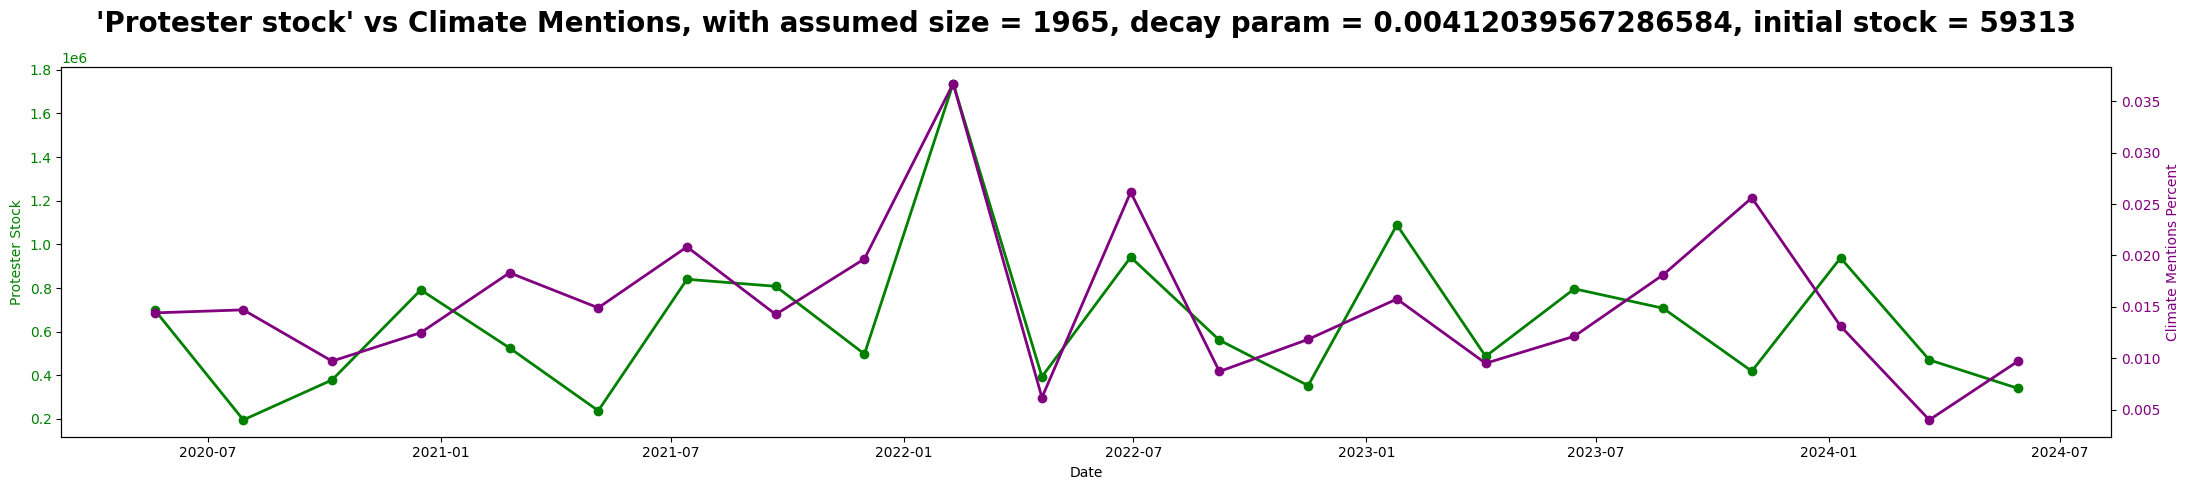

In [29]:
fig, ax1 = plt.subplots(figsize=(22, 5))

protester_color = 'green'
# Plot protest_stock on the primary y-axis
ax1.plot(y_regular.index.to_timestamp(how='end'), ri_adstock_df['protester_stock'], marker='o', linestyle='-', linewidth=2, color=protester_color)
ax1.set_xlabel("Date")
ax1.set_ylabel("Protester Stock", color=protester_color)
ax1.tick_params(axis='y', labelcolor=protester_color)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot climate_mentions_percent on the secondary y-axis
climate_mentions_color = "purple"
ax2.plot(y_regular.index.to_timestamp(how='end'), y_regular, marker='o', linestyle='-', linewidth=2, color=climate_mentions_color)
ax2.set_ylabel("Climate Mentions Percent", color=climate_mentions_color)
ax2.tick_params(axis='y', labelcolor=climate_mentions_color)

# Set title
plt.title(f"'Protester stock' vs Climate Mentions, with assumed size = {assumed_size}, decay param = {decay_param}, initial stock = {initial_stock}", fontsize=20, fontweight="bold", pad=25)

# Adjust layout to prevent clipping of labels
fig.tight_layout()

plt.show()

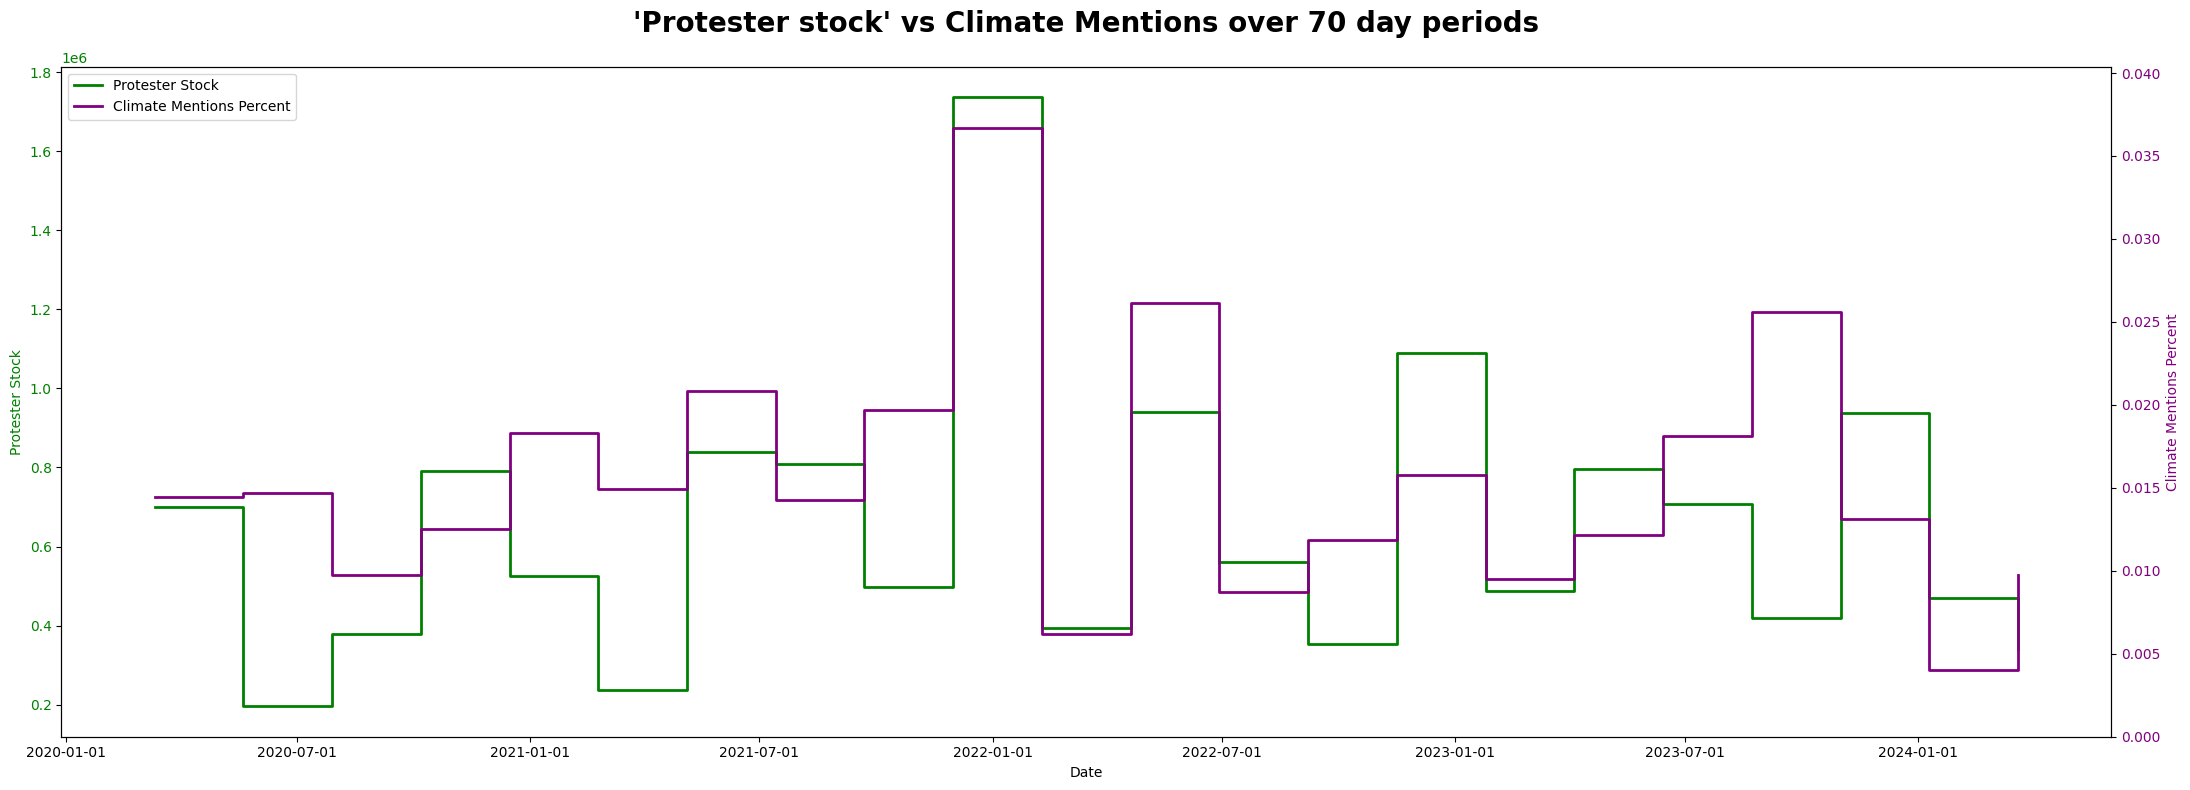

In [42]:
fig, ax = plt.subplots(figsize=(22, 8))

protester_color = 'green'
climate_mentions_color = "purple"

# Plot protest_stock
ax.step(y_regular.index.to_timestamp(how='start'), ri_adstock_df['protester_stock'], where='post', label='Protester Stock', color=protester_color, linewidth=2)

# Set primary y-axis label
ax.set_ylabel("Protester Stock", color=protester_color)
ax.tick_params(axis='y', labelcolor=protester_color)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot climate_mentions_percent on the secondary y-axis
ax2.step(y_regular.index.to_timestamp(how='start'), y_regular, where='post', label='Climate Mentions Percent', color=climate_mentions_color, linewidth=2)

# Set secondary y-axis label and color
ax2.set_ylabel("Climate Mentions Percent", color=climate_mentions_color)
ax2.tick_params(axis='y', labelcolor=climate_mentions_color)

# Set the limits for the secondary y-axis
max_climate_mentions = y_regular.max()
ax2.set_ylim(0, max_climate_mentions * 1.1)  # Set max to 110% of the actual max value

# Set x-axis label
ax.set_xlabel("Date")

# Set title
plt.title(f"'Protester stock' vs Climate Mentions over {min_interval.days} day periods", fontsize=20, fontweight="bold", pad=25)

# Format x-axis labels to show date ranges
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout to prevent clipping of labels
fig.tight_layout()

plt.show()

In [30]:
regularised_protests_df['protester_stock'] = ri_adstock_df['protester_stock']
regularised_protests_df['climate_mentions_percent'] = y_regular
regularised_protests_df[['protester_stock', 'climate_mentions_percent']].corr()

,protester_stock,climate_mentions_percent
protester_stock,1.000000,0.624416
climate_mentions_percent,0.624416,1.000000
